### Decision Tree to Approximate a Sine function
https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

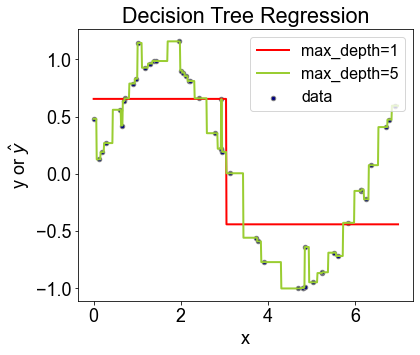

In [161]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(7 * rng.rand(50, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(10))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 7.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(X, y, s=20, edgecolor="gray",
            c="navy", label="data")
plt.plot(X_test, y_1, color="red",
         label="max_depth=1", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("x")
plt.ylabel(r"y or $\^y$")
plt.title("Decision Tree Regression")
plt.legend(fontsize = 16)
plt.show()

### Graident Boosting Method with Decision Trees (Step by Step Illustration)
https://www.kaggle.com/grroverpr/gradient-boosting-simplified/

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

In [162]:
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.display import display
import math
from sklearn import metrics

In [163]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

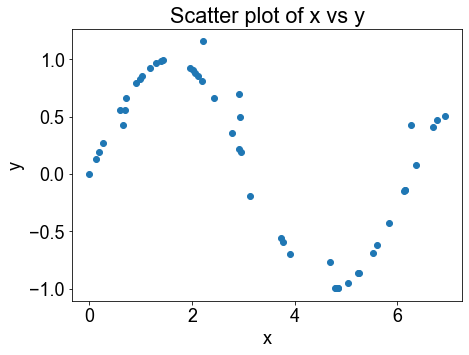

In [166]:
rng = np.random.RandomState(1)
X = 7 * rng.rand(50, 1) #np.sort(7 * rng.rand(50, 1), axis=0)
x = pd.DataFrame({'x':X[:,-1]})
y = np.sin(X).ravel()
y[::5] += 1* (0.5 - rng.rand(10))
y = y[:,None]

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

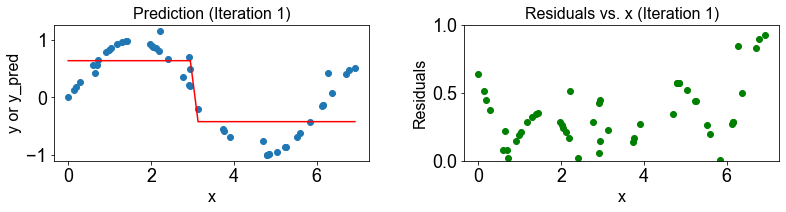

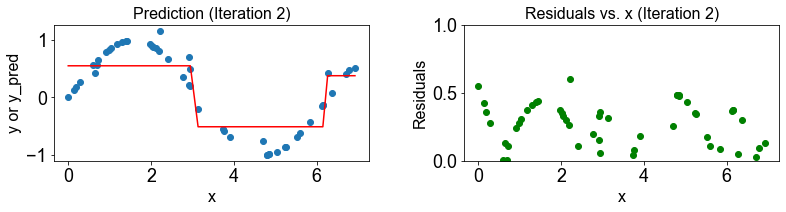

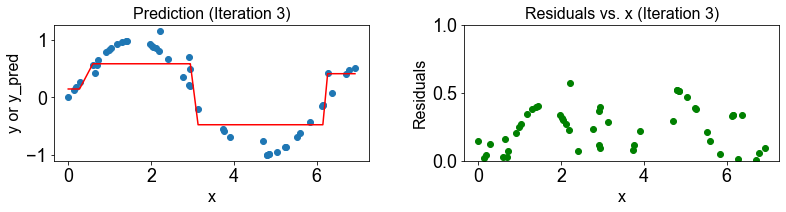

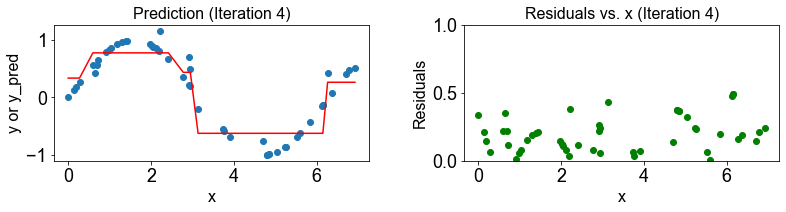

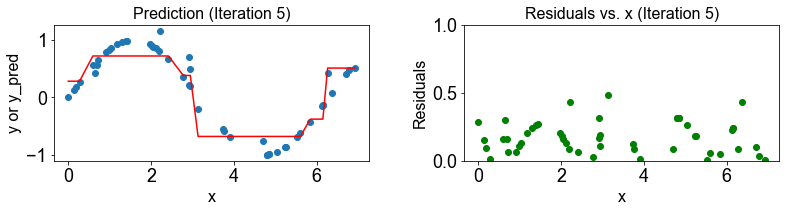

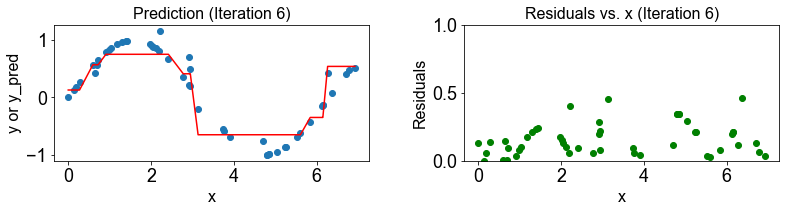

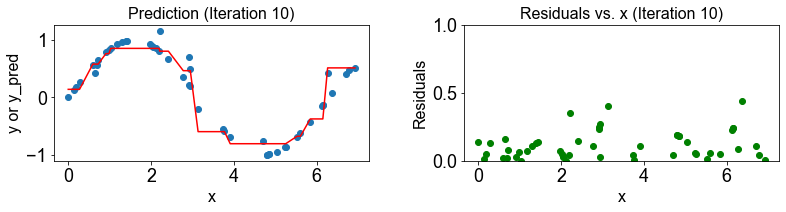

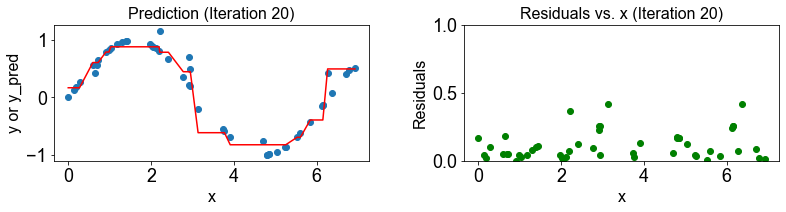

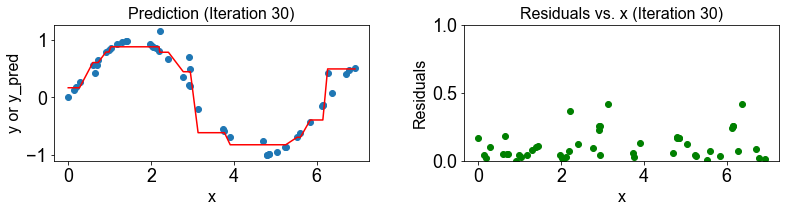

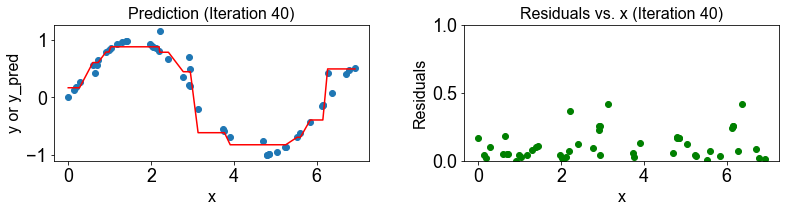

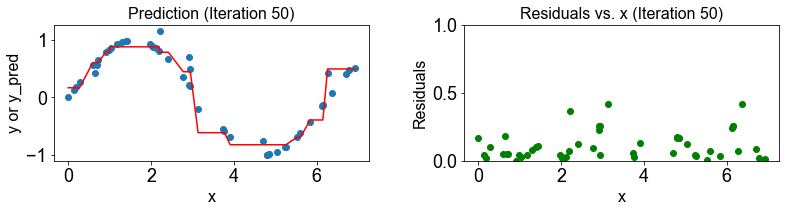

In [165]:
def std_agg(cnt, s1, s2): 
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(50): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]
    plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
    if i<=5:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (13,2.5))
        
        ax1.plot(x,y, 'o')
        ax1.plot(xs, ys, 'r')
        ax1.set_title(f'Prediction (Iteration {i+1})', fontsize = 16)
        ax1.set_xlabel('x', fontsize = 16)
        ax1.set_ylabel('y or y_pred', fontsize = 16)

        ax2.plot(x, abs(ei), 'go')
        ax2.set_title(f'Residuals vs. x (Iteration {i+1})',fontsize = 16)
        ax2.set_xlabel('x', fontsize = 16)
        ax2.set_ylabel('Residuals', fontsize = 16)
        ax2.set_ylim(0,1)
        plt.subplots_adjust(wspace = 0.3)


    else:
        if (i+1)%10 == 0:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (13,2.5))
            ax1.plot(x,y, 'o')
            ax1.plot(xs, ys, 'r')
            ax1.set_title(f'Prediction (Iteration {i+1})', fontsize = 16)
            ax1.set_xlabel('x',fontsize = 16)
            ax1.set_ylabel('y or y_pred', fontsize = 16)

            ax2.plot(x, abs(ei), 'go')
            ax2.set_title(f'Residuals vs. x (Iteration {i+1})', fontsize = 16)
            ax2.set_xlabel('x', fontsize = 16)
            ax2.set_ylabel('Residuals', fontsize = 16)
            ax2.set_ylim(0,1)
            plt.subplots_adjust(wspace = 0.3)
